[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timz815/IAT360-CV-Project/blob/main/CVNotebook.ipynb)

In [ ]:
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu122

# GPU Check
import torch
print("GPU detected:", torch.cuda.device_count())

CUDA available: True
Number of GPUs detected: 1
GPU name: NVIDIA GeForce RTX 4060 Ti
Current device index: 0


In [ ]:
#pip3 install notebook
#pip3 install numpy pandas matplotlib tensorflow opencv-python seaborn pillow

# For local runtime, in cmd/terminal paste: jupyter notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import json
from pathlib import Path

In [ ]:
# =========
# Load Data
# =========

# For MAC
#base_dir = "/Users/tim/Downloads/CV_dataset"

# For Windows
base_dir = r"C:\Users\timot\Downloads\CV_dataset"

ann_dir = os.path.join(base_dir, "ann")
img_dir = os.path.join(base_dir, "img")


# Check if dataset is correct, can comment out
print(f"Dataset Folder found: {os.path.exists(base_dir)}")
print(f"Images found: {sum(len(glob.glob(os.path.join(img_dir, f'*.{ext}'))) for ext in ['png','jpg','jpeg'])}")
print(f"Annotations found: {len(glob.glob(os.path.join(ann_dir, '*.txt')))}")


Dataset Folder found: True
Images found: 5711
Annotations found: 5711


In [ ]:
# ==========
# Clean Data
# ==========

valid_pairs = []
image_files = (glob.glob(os.path.join(img_dir, "*.png")) +
               glob.glob(os.path.join(img_dir, "*.jpg")) +
               glob.glob(os.path.join(img_dir, "*.jpeg")))

for image_file in image_files:
    image_filename = os.path.basename(image_file)
    label_file = os.path.join(ann_dir, image_filename + ".txt")

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            content = f.read().strip()

        if content:  # Simple check like fruit project
            valid_pairs.append((image_file, label_file))

print(f"Found {len(valid_pairs)} valid pairs")

Found 4474 valid pairs


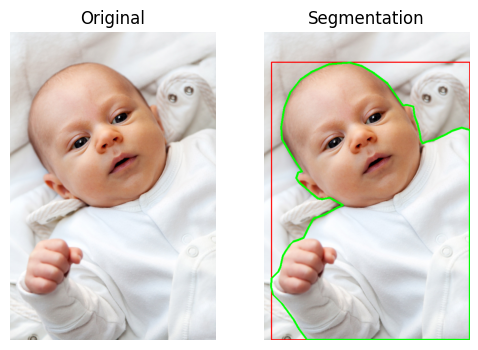

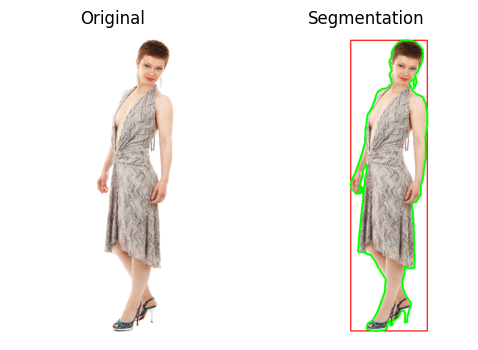

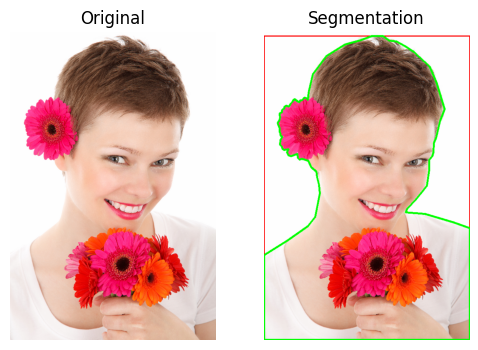

In [ ]:
# ===================
# Visualization Check
# ===================

for i in range(min(3, len(valid_pairs))):
    image_path, ann_path = valid_pairs[i]

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    overlay = image.copy()

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 6:
                # --- Bounding Box ---
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                box_w = float(parts[3]) * width
                box_h = float(parts[4]) * height

                x1 = int(x_center - box_w/2)
                y1 = int(y_center - box_h/2)
                x2 = int(x_center + box_w/2)
                y2 = int(y_center + box_h/2)

                # Red Box
                cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # --- Polygon Mask ---
                polygon_points = []
                for j in range(5, len(parts), 2):
                    if j + 1 < len(parts):
                        x = float(parts[j]) * width
                        y = float(parts[j + 1]) * height
                        polygon_points.append([x, y])

                if len(polygon_points) > 2:
                    pts = np.array(polygon_points, np.int32)
                    # Green Mask
                    cv2.polylines(overlay, [pts], True, (0, 255, 0), 3)

    # Display Config
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Segmentation")
    plt.axis('off')

    # Display
    plt.show()

In [ ]:
# ==================
# Create YAML Config
# ==================

yaml_path = os.path.join(base_dir, "segmentation_config.yaml")
yaml_content = f"""
path: {os.path.join(base_dir, "Final_Seg_Data")}
train: images/train
val: images/val

# Number of classes
nc: 1

# Class names
names:
  0: person
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

In [ ]:
# ===================
# Split and Copy Data
# ===================

base_output_dir = os.path.join(base_dir, "Final_Seg_Data")

train_images_dir = os.path.join(base_output_dir, "images/train")
if os.path.exists(train_images_dir) and len(os.listdir(train_images_dir)) > 0:
    print("Dataset already exists! Skipping file copying.")
    print(f"Found {len(os.listdir(train_images_dir))} images in train folder")
else:
    # Create new directories
    os.makedirs(os.path.join(base_output_dir, "images/train"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "images/val"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "labels/train"), exist_ok=True)
    os.makedirs(os.path.join(base_output_dir, "labels/val"), exist_ok=True)

    # Split data for training and val
    split_idx = int(len(valid_pairs) * 0.8)
    train_pairs = valid_pairs[:split_idx]
    val_pairs = valid_pairs[split_idx:]

    print(f"Training samples: {len(train_pairs)}")
    print(f"Validation samples: {len(val_pairs)}")

    # Copy training data
    for image_path, ann_path in train_pairs:
        filename = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(base_output_dir, "images/train", filename))
        shutil.copy2(ann_path, os.path.join(base_output_dir, "labels/train", os.path.basename(ann_path)))

    # Copy validation data
    for image_path, ann_path in val_pairs:
        filename = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(base_output_dir, "images/val", filename))
        shutil.copy2(ann_path, os.path.join(base_output_dir, "labels/val", os.path.basename(ann_path)))

    print("Data copied successfully!")

    # AUTO-RENAME LABEL FILES
    labels_train_dir = os.path.join(base_output_dir, "labels/train")
    labels_val_dir = os.path.join(base_output_dir, "labels/val")

    # Rename training labels
    train_fixed = 0
    for label_file in os.listdir(labels_train_dir):
        if '.jpeg.txt' in label_file:
            new_name = label_file.replace('.jpeg.txt', '.txt')
        elif '.jpg.txt' in label_file:
            new_name = label_file.replace('.jpg.txt', '.txt')
        elif '.png.txt' in label_file:
            new_name = label_file.replace('.png.txt', '.txt')
        else:
            continue

        old_path = os.path.join(labels_train_dir, label_file)
        new_path = os.path.join(labels_train_dir, new_name)
        os.rename(old_path, new_path)
        train_fixed += 1

    # Rename validation labels
    val_fixed = 0
    for label_file in os.listdir(labels_val_dir):
        if '.jpeg.txt' in label_file:
            new_name = label_file.replace('.jpeg.txt', '.txt')
        elif '.jpg.txt' in label_file:
            new_name = label_file.replace('.jpg.txt', '.txt')
        elif '.png.txt' in label_file:
            new_name = label_file.replace('.png.txt', '.txt')
        else:
            continue

        old_path = os.path.join(labels_val_dir, label_file)
        new_path = os.path.join(labels_val_dir, new_name)
        os.rename(old_path, new_path)
        val_fixed += 1

    # Print only if files were fixed
    if train_fixed > 0 or val_fixed > 0:
        print(f"Fixed {train_fixed} training labels and {val_fixed} validation labels")


Dataset already exists! Skipping file copying.
Found 3579 images in train folder


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()


Ultralytics 8.3.221  Python-3.13.1 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Setup complete  (24 CPUs, 29.7 GB RAM, 790.4/928.7 GB disk)


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-seg.pt')
model.train(
    data=os.path.join(base_dir, "segmentation_config.yaml"),
    epochs=15,
    patience=10,  #test
    batch=8,
    lr0=0.0005,   #test
    imgsz=640,
    #device='cuda' #'auto'
)

Ultralytics 8.3.221  Python-3.13.1 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\timot\Downloads\CV_dataset\segmentation_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000231881565D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0

In [ ]:
# ==============
# Validate Model
# ==============

# 1. CONFUSION MATRIX
if hasattr(results, 'confusion_matrix') and results.confusion_matrix is not None:
    results.confusion_matrix.plot()
    plt.title('Confusion Matrix - Person Segmentation')
    plt.show()

# 2. METRICS EXTRACTION
metrics = results.results_dict
print("\n=== VALIDATION METRICS ===")
print(f"mAP50: {metrics.get('metrics/mAP50(B)', 0):.3f}")
print(f"mAP50-95: {metrics.get('metrics/mAP50-95(B)', 0):.3f}")
print(f"Precision: {metrics.get('metrics/precision(B)', 0):.3f}")
print(f"Recall: {metrics.get('metrics/recall(B)', 0):.3f}")

Ultralytics 8.3.221  Python-3.13.1 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 1045.3388.0 MB/s, size: 918.9 KB)
val: Scanning C:\Users\timot\Downloads\CV_dataset\Final_Seg_Data\labels\val.cache... 895 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 895/895 758.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 4.4it/s 12.8s
                   all        895        992      0.783      0.868      0.917      0.744      0.847      0.725      0.829      0.416
Speed: 1.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to C:\Users\timot\runs\segment\val2
mAP50-95: 0.7444
mAP50: 0.9174
Precision: 0.7831
Recall: 0.8679
Mask mAP50-95: 0.4165
Mask mAP50: 0.8291


In [ ]:
# =======
# Metrics
# =======

# Calculate F1 Score
precision = metrics.get('metrics/precision(B)', 0)
recall = metrics.get('metrics/recall(B)', 0)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1 Score: {f1_score:.3f}")

# 3. F1 CURVE GRAPH (across different confidence thresholds)
try:
    # Get precision-recall data across confidence thresholds
    if hasattr(results, 'curves') and hasattr(results.curves, 'pr'):
        pr_curve = results.curves.pr  # Precision-Recall curve data

        # Calculate F1 across different confidence thresholds
        confidence_thresholds = np.linspace(0.1, 0.9, 50)  # Range of confidence thresholds
        f1_scores = []

        # For each confidence threshold, calculate F1 score
        for conf in confidence_thresholds:
            # Get precision and recall at this confidence level
            # This is a simplified approach - YOLO stores these values internally
            prec = np.interp(conf, pr_curve.conf, pr_curve.p) if hasattr(pr_curve, 'conf') else precision
            rec = np.interp(conf, pr_curve.conf, pr_curve.r) if hasattr(pr_curve, 'conf') else recall

            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
            f1_scores.append(f1)

        # Plot F1 Curve
        plt.figure(figsize=(10, 6))
        plt.plot(confidence_thresholds, f1_scores, 'b-', linewidth=2, label='F1 Score')
        plt.fill_between(confidence_thresholds, f1_scores, alpha=0.2, color='blue')

        # Find optimal confidence threshold (max F1)
        optimal_idx = np.argmax(f1_scores)
        optimal_conf = confidence_thresholds[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]

        plt.axvline(x=optimal_conf, color='red', linestyle='--',
                   label=f'Optimal Confidence: {optimal_conf:.2f}\nF1: {optimal_f1:.3f}')
        plt.scatter(optimal_conf, optimal_f1, color='red', s=100, zorder=5)

        plt.xlabel('Confidence Threshold')
        plt.ylabel('F1 Score')
        plt.title('F1 Score vs Confidence Threshold\nPerson Segmentation')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        plt.xlim(0.1, 0.9)
        plt.show()

        print(f"Optimal confidence threshold: {optimal_conf:.3f}")
        print(f"Maximum F1 score: {optimal_f1:.3f}")

    else:
        # Fallback: Create F1 curve using precision-recall tradeoff
        print("Creating F1 curve from precision-recall tradeoff...")

        # Simulate precision-recall tradeoff
        recall_levels = np.linspace(0.1, 0.9, 50)
        precision_levels = np.linspace(precision - 0.2, precision + 0.2, 50)
        precision_levels = np.clip(precision_levels, 0, 1)

        f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0
                    for p, r in zip(precision_levels, recall_levels)]

        plt.figure(figsize=(10, 6))
        plt.plot(recall_levels, f1_scores, 'g-', linewidth=2, label='F1 Score')
        plt.xlabel('Recall')
        plt.ylabel('F1 Score')
        plt.title('F1 Score vs Recall\nPerson Segmentation')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        plt.show()

except Exception as e:
    print(f"Could not create detailed F1 curve: {e}")

    # Simple F1 visualization as fallback
    plt.figure(figsize=(8, 6))
    plt.bar(['F1 Score'], [f1_score], color='skyblue', alpha=0.7)
    plt.axhline(y=f1_score, color='red', linestyle='-', alpha=0.8)
    plt.text(0, f1_score + 0.02, f'{f1_score:.3f}', ha='center', fontsize=12)
    plt.ylabel('Score')
    plt.title(f'F1 Score - Person Segmentation\nCurrent: {f1_score:.3f}')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.show()
# 4. PRECISION-RECALL CURVE (shows F1 isolines)
try:
    if hasattr(results, 'curves') and results.curves is not None:
        # Plot PR curve with F1 isolines
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot PR curve
        results.curves.plot()

        # Add F1 isolines
        f1_levels = [0.2, 0.4, 0.6, 0.8]
        for f1 in f1_levels:
            recall_vals = np.linspace(0.01, 1, 100)
            precision_vals = [f1 * r / (2 * r - f1) if (2 * r - f1) > 0 else 0 for r in recall_vals]
            ax.plot(recall_vals, precision_vals, '--', alpha=0.5, label=f'F1={f1}')

        plt.title('Precision-Recall Curve with F1 Isolines\nPerson Segmentation')
        plt.legend()
        plt.show()

except Exception as e:
    print(f"Could not create PR curve with F1 isolines: {e}")


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 C:\Users\timot\bus.jpg: 640x480 2 persons, 235.8ms
Speed: 10.6ms preprocess, 235.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to C:\Users\timot\runs\segment\predict
